# Day 2 – Order Book Implementation

In [2]:
import heapq
import copy

class Order:
    def __init__(self, order_id, side, price, qty, timestamp):
        self.id = order_id
        self.side = side  # 'buy' or 'sell'
        self.price = float(price)
        self.qty = int(qty)
        self.timestamp = timestamp

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def __repr__(self):
        return f"[{self.side.upper()} {self.id} @ {self.price:.2f} x {self.qty}]"

class OrderBook:
    def __init__(self):
        self.bids = []
        self.asks = []
        self.trades = []

    def add_order(self, order):
        if order.side == 'buy':
            heapq.heappush(self.bids, (-order.price, order.timestamp, order))
        else:
            heapq.heappush(self.asks, (order.price, order.timestamp, order))
        self.match_orders()

    def match_orders(self):
        while self.bids and self.asks:
            best_bid_stack = self.bids[0]
            best_ask_stack = self.asks[0]

            best_bid_price = -best_bid_stack[0]
            best_ask_price = best_ask_stack[0]
            best_bid_order = best_bid_stack[2]
            best_ask_order = best_ask_stack[2]

            if best_bid_price < best_ask_price:
                break

            trade_price = best_ask_order.price if best_ask_order.timestamp < best_bid_order.timestamp else best_bid_order.price
            trade_qty = min(best_bid_order.qty, best_ask_order.qty)

            self.trades.append({
                "price": trade_price,
                "qty": trade_qty,
                "buyer": best_bid_order.id,
                "seller": best_ask_order.id,
                "timestamp": max(best_bid_order.timestamp, best_ask_order.timestamp)
            })

            best_bid_order.qty -= trade_qty
            best_ask_order.qty -= trade_qty

            if best_bid_order.qty == 0:
                heapq.heappop(self.bids)
            if best_ask_order.qty == 0:
                heapq.heappop(self.asks)

    def print_depth(self, level=5):
        print(f"\n--- Order Book Depth (Top {level}) ---")
        sorted_asks = sorted(self.asks)[:level]
        sorted_bids = sorted(self.bids)[:level]
        print(f"{'BID (Buy)':<30} | {'ASK (Sell)':>30}")
        print("-" * 65)
        for _, _, order in reversed(sorted_asks):
             print(f"{' ':<30} | {order.price:8.2f} x {order.qty:<4} (ID: {order.id})")
        for _, _, order in sorted_bids:
             print(f"(ID: {order.id}) {order.price:8.2f} x {order.qty:<4} |")
        print("-" * 65)

In [3]:
def run_simulation(run_id):
    print(f"\n=== SIMULATION RUN: {run_id} ===")
    book = OrderBook()

    orders_data = [
        (1, 'buy', 100.0, 10, 1),
        (2, 'sell', 105.0, 10, 2),
        (3, 'buy', 99.0, 5, 3),
        (4, 'sell', 106.0, 20, 4),
        (5, 'buy', 105.0, 5, 5),
        (6, 'sell', 98.0, 12, 6)
    ]

    for data in orders_data:
        o = Order(*data)
        book.add_order(o)

    book.print_depth(5)

    print(f"Trades Executed: {len(book.trades)}")
    for t in book.trades:
        print(f"  -> {t['qty']} @ {t['price']} (Buy:{t['buyer']} / Sell:{t['seller']})")

    return book.trades

# Execute
trades_1 = run_simulation(1)
trades_2 = run_simulation(2)

print("\n=== VERIFICATION ===")
if trades_1 == trades_2:
    print("✅ SUCCESS: Both runs produced identical trades.")
else:
    print("❌ FAILURE: Non-deterministic behavior detected.")


=== SIMULATION RUN: 1 ===

--- Order Book Depth (Top 5) ---
BID (Buy)                      |                     ASK (Sell)
-----------------------------------------------------------------
                               |   106.00 x 20   (ID: 4)
                               |   105.00 x 5    (ID: 2)
(ID: 3)    99.00 x 3    |
-----------------------------------------------------------------
Trades Executed: 3
  -> 5 @ 105.0 (Buy:5 / Sell:2)
  -> 10 @ 100.0 (Buy:1 / Sell:6)
  -> 2 @ 99.0 (Buy:3 / Sell:6)

=== SIMULATION RUN: 2 ===

--- Order Book Depth (Top 5) ---
BID (Buy)                      |                     ASK (Sell)
-----------------------------------------------------------------
                               |   106.00 x 20   (ID: 4)
                               |   105.00 x 5    (ID: 2)
(ID: 3)    99.00 x 3    |
-----------------------------------------------------------------
Trades Executed: 3
  -> 5 @ 105.0 (Buy:5 / Sell:2)
  -> 10 @ 100.0 (Buy:1 / Sell:6)
  -> 2 

## Day 3 – Liquidity and Market Depth

Simulating BlueChip Stock (Vol: 0.5, Arrival Rate: 5)...
Simulating Volatile Crypto (Vol: 2.5, Arrival Rate: 2)...


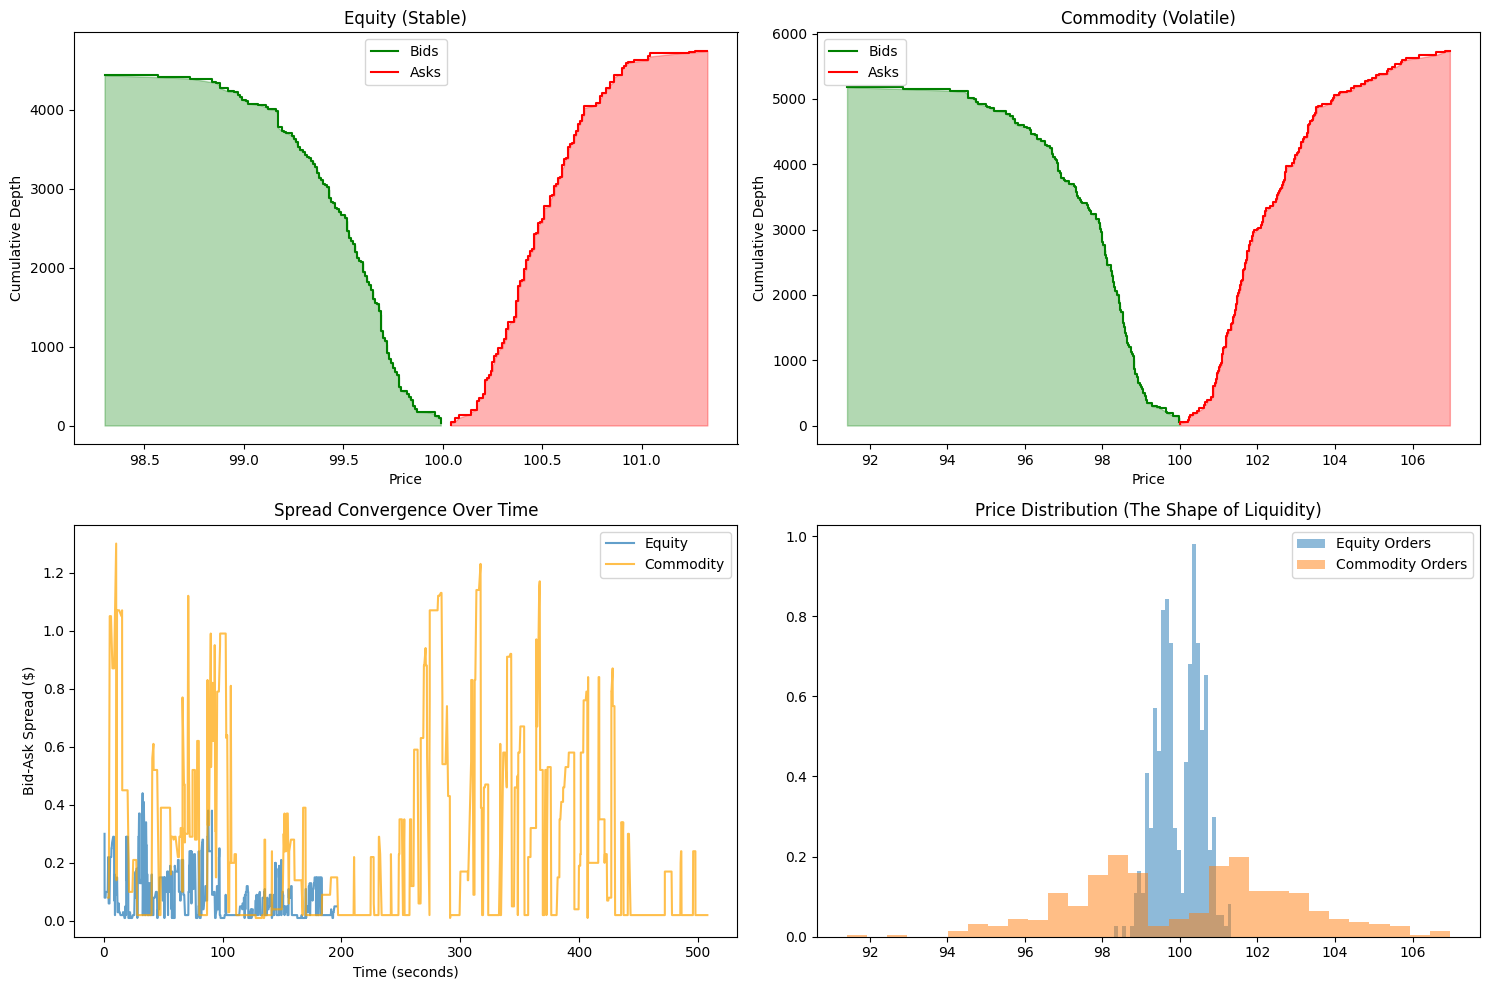

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import heapq

# --- RE-USING YOUR CLASS STRUCTURE (Compact Version) ---
class Order:
    def __init__(self, order_id, side, price, qty, timestamp):
        self.id = order_id
        self.side = side
        self.price = float(price)
        self.qty = int(qty)
        self.timestamp = timestamp

    def __lt__(self, other):
        return self.timestamp < other.timestamp

class OrderBook:
    def __init__(self, name):
        self.name = name
        self.bids = [] # Max-heap (negative price)
        self.asks = [] # Min-heap
        self.spread_history = [] # To track convergence
        self.timestamps = []

    def add(self, order):
        if order.side == 'buy':
            heapq.heappush(self.bids, (-order.price, order.timestamp, order))
        else:
            heapq.heappush(self.asks, (order.price, order.timestamp, order))
        self.match()
        self.record_spread(order.timestamp)

    def match(self):
        while self.bids and self.asks:
            best_bid = -self.bids[0][0]
            best_ask = self.asks[0][0]
            if best_bid < best_ask: break

            # Simplified match logic for simulation speed
            bid_qty = self.bids[0][2].qty
            ask_qty = self.asks[0][2].qty
            match_qty = min(bid_qty, ask_qty)

            self.bids[0][2].qty -= match_qty
            self.asks[0][2].qty -= match_qty

            if self.bids[0][2].qty == 0: heapq.heappop(self.bids)
            if self.asks[0][2].qty == 0: heapq.heappop(self.asks)

    def record_spread(self, timestamp):
        # Only record if we have both sides
        if self.bids and self.asks:
            best_bid = -self.bids[0][0]
            best_ask = self.asks[0][0]
            spread = best_ask - best_bid
            self.spread_history.append(spread)
            self.timestamps.append(timestamp)

# --- SIMULATION ENGINE ---
def run_simulation(asset_name, volatility, lambda_arrival, num_orders=1000):
    book = OrderBook(asset_name)
    current_time = 0.0
    mid_price = 100.0

    print(f"Simulating {asset_name} (Vol: {volatility}, Arrival Rate: {lambda_arrival})...")

    for i in range(num_orders):
        # 1. POISSON PROCESS FOR TIME
        # The time between orders is exponentially distributed
        inter_arrival_time = np.random.exponential(1.0 / lambda_arrival)
        current_time += inter_arrival_time

        # 2. DETERMINE ORDER SIDE & PRICE
        side = 'buy' if random.random() < 0.5 else 'sell'

        # Volatility determines how "spread out" the limit orders are
        # High Volatility = Wide bell curve (Commodity)
        # Low Volatility = Narrow bell curve (Equity)
        price_noise = np.random.normal(0, volatility)
        price = round(mid_price + price_noise, 2)

        # Smart Logic: Don't place bids way above market or asks way below
        # (This mimics "marketable limit orders" vs "passive limit orders")
        if side == 'buy' and price > mid_price + volatility: price = mid_price - 0.01
        if side == 'sell' and price < mid_price - volatility: price = mid_price + 0.01

        qty = random.randint(1, 50)
        book.add(Order(i, side, price, qty, current_time))

    return book

# --- VISUALIZATION ---
def plot_results(book_equity, book_commodity):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Helper to get depth data
    def get_depth(book):
        bids = sorted([(-p, q.qty) for p, t, q in book.bids], reverse=True)
        asks = sorted([(p, q.qty) for p, t, q in book.asks])
        bid_px, bid_vol = [x[0] for x in bids], np.cumsum([x[1] for x in bids])
        ask_px, ask_vol = [x[0] for x in asks], np.cumsum([x[1] for x in asks])
        return bid_px, bid_vol, ask_px, ask_vol

    # 1. DEPTH CHARTS
    for ax, book, title in zip([axes[0,0], axes[0,1]], [book_equity, book_commodity], ["Equity (Stable)", "Commodity (Volatile)"]):
        bp, bv, ap, av = get_depth(book)
        ax.fill_between(bp, bv, color='green', alpha=0.3)
        ax.step(bp, bv, color='green', label='Bids')
        ax.fill_between(ap, av, color='red', alpha=0.3)
        ax.step(ap, av, color='red', label='Asks')
        ax.set_title(title)
        ax.set_xlabel("Price")
        ax.set_ylabel("Cumulative Depth")
        ax.legend()

    # 2. SPREAD CONVERGENCE
    # This plots the Bid-Ask Spread over time.
    # Expectation: It starts wide and volatile, then settles (converges).
    ax_spread = axes[1,0]
    ax_spread.plot(book_equity.timestamps, book_equity.spread_history, label='Equity', alpha=0.7)
    ax_spread.plot(book_commodity.timestamps, book_commodity.spread_history, label='Commodity', alpha=0.7, color='orange')
    ax_spread.set_title("Spread Convergence Over Time")
    ax_spread.set_xlabel("Time (seconds)")
    ax_spread.set_ylabel("Bid-Ask Spread ($)")
    ax_spread.legend()

    # 3. VOLATILITY VISUALIZATION (Histogram of resting orders)
    ax_hist = axes[1,1]
    equity_prices = [q.price for p,t,q in book_equity.bids + book_equity.asks]
    comm_prices = [q.price for p,t,q in book_commodity.bids + book_commodity.asks]

    ax_hist.hist(equity_prices, bins=30, alpha=0.5, label='Equity Orders', density=True)
    ax_hist.hist(comm_prices, bins=30, alpha=0.5, label='Commodity Orders', density=True)
    ax_hist.set_title("Price Distribution (The Shape of Liquidity)")
    ax_hist.legend()

    plt.tight_layout()
    plt.show()

# --- RUN EXPERIMENT ---
# Equity: Low Volatility (0.5), Fast Arrival (Lambda=5)
book_eq = run_simulation("BlueChip Stock", volatility=0.5, lambda_arrival=5)

# Commodity: High Volatility (2.5), Slower Arrival (Lambda=2)
book_comm = run_simulation("Volatile Crypto", volatility=2.5, lambda_arrival=2)

plot_results(book_eq, book_comm)

# Day 4 – System Architecture Blueprint

--- Simulation Start (500 ticks) ---
--- Simulation End. Total Trades: 3470 ---


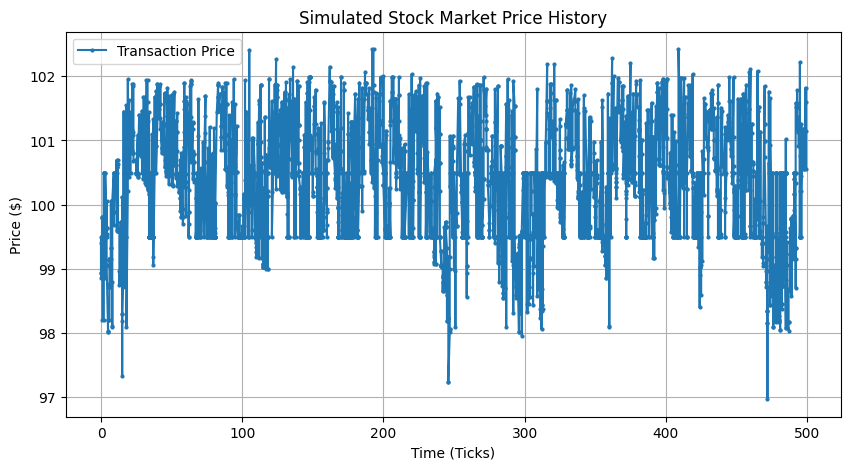


Sample Trade Log:
   Time  Price  Qty Aggressor   Passive
0     0  98.85   10  Noise_14   Noise_5
1     0  99.41    3     MM_01  Noise_12
2     0  99.50    2  Noise_15     MM_01
3     0  98.94    4   Noise_0  Noise_15
4     0  98.94    4  Noise_11  Noise_15


In [6]:
import heapq
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from abc import ABC, abstractmethod

# ==========================================
# LAYER 1: THE MARKET MICROSTRUCTURE (EXCHANGE)
# ==========================================

class Order:
    def __init__(self, agent_id, side, price, qty, timestamp):
        self.agent_id = agent_id
        self.side = side
        self.price = round(float(price), 2)
        self.qty = int(qty)
        self.timestamp = timestamp
        self.id = f"{agent_id}_{int(timestamp*100000)}_{random.randint(10,99)}"

    def __lt__(self, other):
        return self.timestamp < other.timestamp

class Exchange:
    def __init__(self, ticker="ABC"):
        self.ticker = ticker
        self.bids = [] # Max Heap (-price)
        self.asks = [] # Min Heap (+price)
        self.trade_log = []
        self.current_time = 0

    def get_best_bid(self):
        return -self.bids[0][0] if self.bids else None

    def get_best_ask(self):
        return self.asks[0][0] if self.asks else None

    def get_mid_price(self):
        bid = self.get_best_bid()
        ask = self.get_best_ask()
        if bid and ask:
            return (bid + ask) / 2.0
        return 100.0 # Default starting price

    def submit_order(self, order):
        # 1. Matching Logic
        if order.side == 'buy':
            # Check against Asks
            while self.asks and order.qty > 0:
                best_ask_price = self.asks[0][0]
                if order.price >= best_ask_price: # Crosses spread
                    self._execute_trade(order, self.asks[0])
                else:
                    break
            if order.qty > 0:
                heapq.heappush(self.bids, (-order.price, order.timestamp, order))

        else: # Sell
            # Check against Bids
            while self.bids and order.qty > 0:
                best_bid_price = -self.bids[0][0]
                if order.price <= best_bid_price: # Crosses spread
                    self._execute_trade(order, self.bids[0])
                else:
                    break
            if order.qty > 0:
                heapq.heappush(self.asks, (order.price, order.timestamp, order))

    def _execute_trade(self, aggressor, resting_tuple):
        # Unpack resting order (price, timestamp, order_obj)
        resting_order = resting_tuple[2]

        trade_price = resting_order.price # Price is always the resting price
        trade_qty = min(aggressor.qty, resting_order.qty)

        # Log Trade
        self.trade_log.append({
            "Time": self.current_time,
            "Price": trade_price,
            "Qty": trade_qty,
            "Aggressor": aggressor.agent_id,
            "Passive": resting_order.agent_id
        })

        # Update Quantities
        aggressor.qty -= trade_qty
        resting_order.qty -= trade_qty

        # Cleanup Heaps if filled
        if resting_order.qty == 0:
            if resting_order.side == 'buy':
                heapq.heappop(self.bids)
            else:
                heapq.heappop(self.asks)

# ==========================================
# LAYER 2: THE AGENTS (STRATEGIES)
# ==========================================

class Agent(ABC):
    def __init__(self, agent_id, initial_cash=10000, initial_stock=0):
        self.id = agent_id
        self.cash = initial_cash
        self.stock = initial_stock

    @abstractmethod
    def act(self, exchange):
        pass

class NoiseTrader(Agent):
    """
    Randomly buys or sells. Simulates retail flow or news events.
    """
    def act(self, exchange):
        if random.random() > 0.3: return # Only trade 30% of the time

        mid = exchange.get_mid_price()
        side = 'buy' if random.random() < 0.5 else 'sell'

        # Aggressive orders (Market Orders disguised as Limits)
        if side == 'buy':
            price = mid + random.uniform(0.1, 2.0)
        else:
            price = mid - random.uniform(0.1, 2.0)

        qty = random.randint(1, 10)
        return Order(self.id, side, price, qty, exchange.current_time)

class MarketMaker(Agent):
    """
    Provides liquidity. Places a Buy below Mid and Sell above Mid.
    Profits from the Spread.
    """
    def act(self, exchange):
        mid = exchange.get_mid_price()
        spread_half = 0.50 # Wants to earn $1.00 spread

        orders = []
        # Place Bid
        orders.append(Order(self.id, 'buy', mid - spread_half, 5, exchange.current_time))
        # Place Ask
        orders.append(Order(self.id, 'sell', mid + spread_half, 5, exchange.current_time))

        return orders

# ==========================================
# LAYER 3: THE SIMULATOR (ORCHESTRATOR)
# ==========================================

def run_market_simulation(ticks=100):
    exchange = Exchange()

    # Initialize Agents
    agents = []
    # 20 Noise Traders
    for i in range(20):
        agents.append(NoiseTrader(f"Noise_{i}"))
    # 1 Market Maker
    mm = MarketMaker("MM_01")
    agents.append(mm)

    print(f"--- Simulation Start ({ticks} ticks) ---")

    # Simulation Loop
    for t in range(ticks):
        exchange.current_time = t

        # Shuffle agents so they don't always act in same order
        random.shuffle(agents)

        for agent in agents:
            action = agent.act(exchange)

            if action:
                if isinstance(action, list): # Agent returned multiple orders
                    for o in action:
                        exchange.submit_order(o)
                elif isinstance(action, Order):
                    exchange.submit_order(action)

    print(f"--- Simulation End. Total Trades: {len(exchange.trade_log)} ---")
    return exchange

# ==========================================
# EXECUTION & VISUALIZATION
# ==========================================

simulated_exchange = run_market_simulation(ticks=500)

# Convert trade log to DataFrame for easy analysis
if simulated_exchange.trade_log:
    df = pd.DataFrame(simulated_exchange.trade_log)

    # Plotting the Price Series
    plt.figure(figsize=(10, 5))
    plt.plot(df['Time'], df['Price'], label='Transaction Price', marker='o', markersize=2)
    plt.title("Simulated Stock Market Price History")
    plt.xlabel("Time (Ticks)")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("\nSample Trade Log:")
    print(df.head())
else:
    print("No trades occurred. Try increasing ticks or agent aggressiveness.")

# WEEK_1_Final_Deliverables

--- Simulation Start (500 ticks) ---
--- Simulation End. Total Trades: 3525 ---


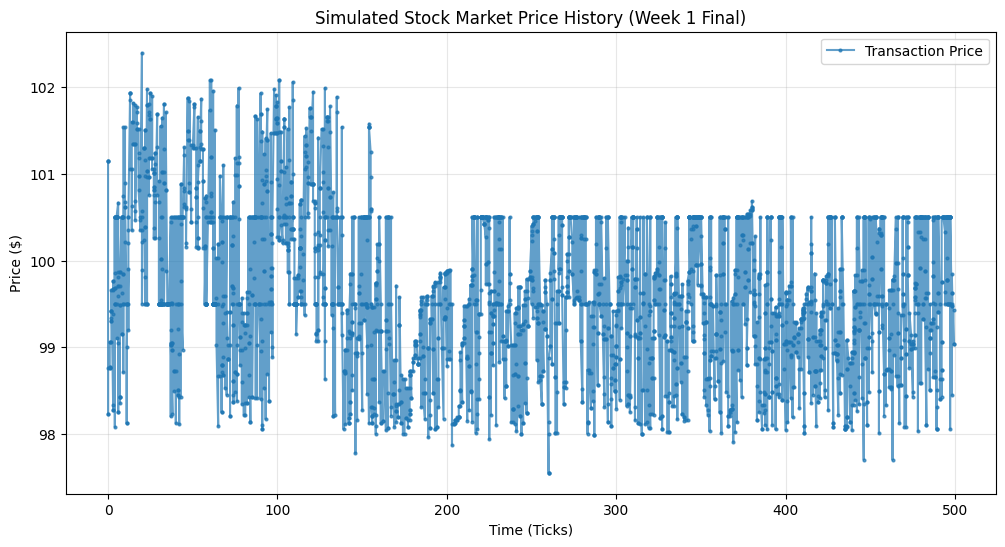


Sample Trade Log (First 5 Trades):
   Time   Price  Qty Aggressor   Passive
0     0  101.15    2  Noise_13   Noise_0
1     0  101.15    6   Noise_1   Noise_0
2     0  101.15    2  Noise_14   Noise_0
3     0   98.23    5     MM_01  Noise_10
4     0   98.23    5   Noise_4  Noise_10

Final Statistics:
Total Volume Traded: 10578
VWAP (Volume Weighted Avg Price): 99.64


In [7]:
import heapq
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from abc import ABC, abstractmethod
import time

# ==========================================
# LAYER 1: THE MARKET MICROSTRUCTURE (EXCHANGE)
# ==========================================

class Order:
    def __init__(self, agent_id, side, price, qty, timestamp):
        self.agent_id = agent_id
        self.side = side # 'buy' or 'sell'
        self.price = round(float(price), 2)
        self.qty = int(qty)
        self.timestamp = timestamp
        # Unique ID for tracking
        self.id = f"{agent_id}_{int(timestamp*100000)}_{random.randint(10,99)}"

    # Priority comparison for Heaps: Lower timestamp = Higher priority
    def __lt__(self, other):
        return self.timestamp < other.timestamp

class Exchange:
    def __init__(self, ticker="ABC"):
        self.ticker = ticker
        self.bids = [] # Max Heap (stored as negative prices)
        self.asks = [] # Min Heap (stored as positive prices)
        self.trade_log = []
        self.current_time = 0

    def get_best_bid(self):
        # Return positive price if exists, else None
        return -self.bids[0][0] if self.bids else None

    def get_best_ask(self):
        return self.asks[0][0] if self.asks else None

    def get_mid_price(self):
        bid = self.get_best_bid()
        ask = self.get_best_ask()
        if bid and ask:
            return (bid + ask) / 2.0
        return 100.0 # Default starting price if book is empty

    def submit_order(self, order):
        # 1. Matching Logic
        if order.side == 'buy':
            # Buy order looks for Asks (Sellers)
            while self.asks and order.qty > 0:
                best_ask_price = self.asks[0][0]
                if order.price >= best_ask_price: # Aggressive Buy crosses spread
                    self._execute_trade(order, self.asks[0])
                else:
                    break # Spread not crossed
            # If quantity remains, place in Book (Resting Order)
            if order.qty > 0:
                heapq.heappush(self.bids, (-order.price, order.timestamp, order))

        else: # Sell order looks for Bids (Buyers)
            while self.bids and order.qty > 0:
                best_bid_price = -self.bids[0][0]
                if order.price <= best_bid_price: # Aggressive Sell crosses spread
                    self._execute_trade(order, self.bids[0])
                else:
                    break
            if order.qty > 0:
                heapq.heappush(self.asks, (order.price, order.timestamp, order))

    def _execute_trade(self, aggressor, resting_tuple):
        # Unpack resting order (price, timestamp, order_obj)
        resting_order = resting_tuple[2]

        # Trade happens at the RESTING order's price
        trade_price = resting_order.price
        trade_qty = min(aggressor.qty, resting_order.qty)

        # Log the Trade
        self.trade_log.append({
            "Time": self.current_time,
            "Price": trade_price,
            "Qty": trade_qty,
            "Aggressor": aggressor.agent_id,
            "Passive": resting_order.agent_id
        })

        # Update Quantities
        aggressor.qty -= trade_qty
        resting_order.qty -= trade_qty

        # Cleanup Heaps if filled
        if resting_order.qty == 0:
            if resting_order.side == 'buy':
                heapq.heappop(self.bids)
            else:
                heapq.heappop(self.asks)

# ==========================================
# LAYER 2: THE AGENTS (STRATEGIES)
# ==========================================

class Agent(ABC):
    def __init__(self, agent_id, initial_cash=10000, initial_stock=0):
        self.id = agent_id
        self.cash = initial_cash
        self.stock = initial_stock

    @abstractmethod
    def act(self, exchange):
        pass

class NoiseTrader(Agent):
    """
    Randomly buys or sells. Simulates retail flow or news events.
    They create volume and volatility.
    """
    def act(self, exchange):
        if random.random() > 0.3: return # Only trade 30% of the time

        mid = exchange.get_mid_price()
        side = 'buy' if random.random() < 0.5 else 'sell'

        # Aggressive orders (Market Orders disguised as Limits)
        # Adds noise/variance to the price
        if side == 'buy':
            price = mid + random.uniform(0.1, 2.0)
        else:
            price = mid - random.uniform(0.1, 2.0)

        qty = random.randint(1, 10)
        return Order(self.id, side, price, qty, exchange.current_time)

class MarketMaker(Agent):
    """
    Provides liquidity. Places a Buy below Mid and Sell above Mid.
    Profits from the Spread.
    """
    def act(self, exchange):
        mid = exchange.get_mid_price()
        spread_half = 0.50 # Wants to earn $1.00 spread

        orders = []
        # Place Bid (Buy low)
        orders.append(Order(self.id, 'buy', mid - spread_half, 5, exchange.current_time))
        # Place Ask (Sell high)
        orders.append(Order(self.id, 'sell', mid + spread_half, 5, exchange.current_time))

        return orders

# ==========================================
# LAYER 3: THE SIMULATOR (ORCHESTRATOR)
# ==========================================

def run_market_simulation(ticks=500):
    exchange = Exchange()

    # Initialize Agents
    agents = []

    # 20 Noise Traders (The "Crowd")
    for i in range(20):
        agents.append(NoiseTrader(f"Noise_{i}"))

    # 1 Market Maker (The "House")
    mm = MarketMaker("MM_01")
    agents.append(mm)

    print(f"--- Simulation Start ({ticks} ticks) ---")

    # Simulation Loop
    for t in range(ticks):
        exchange.current_time = t

        # Shuffle agents so they don't always act in same order (Fairness)
        random.shuffle(agents)

        for agent in agents:
            action = agent.act(exchange)

            if action:
                if isinstance(action, list): # Agent returned multiple orders
                    for o in action:
                        exchange.submit_order(o)
                elif isinstance(action, Order):
                    exchange.submit_order(action)

    print(f"--- Simulation End. Total Trades: {len(exchange.trade_log)} ---")
    return exchange

# ==========================================
# EXECUTION & VISUALIZATION
# ==========================================

# Run the simulation
simulated_exchange = run_market_simulation(ticks=500)

# Convert trade log to DataFrame for easy analysis
if simulated_exchange.trade_log:
    df = pd.DataFrame(simulated_exchange.trade_log)

    # Plotting the Price Series
    plt.figure(figsize=(12, 6))
    plt.plot(df['Time'], df['Price'], label='Transaction Price', marker='o', markersize=2, alpha=0.7)
    plt.title("Simulated Stock Market Price History (Week 1 Final)")
    plt.xlabel("Time (Ticks)")
    plt.ylabel("Price ($)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Show first few trades
    print("\nSample Trade Log (First 5 Trades):")
    print(df.head())

    # Basic Stats
    print(f"\nFinal Statistics:")
    print(f"Total Volume Traded: {df['Qty'].sum()}")
    print(f"VWAP (Volume Weighted Avg Price): {(df['Price'] * df['Qty']).sum() / df['Qty'].sum():.2f}")
else:
    print("No trades occurred. Try increasing ticks or agent aggressiveness.")